# Analisi finale

Si individuando 5 quadrati con dimensione 50*50 pixel attorno a delle minutiae (punti caratteristici) di interesse per entrambe le immagini. Le aree vengono individuate sulla prima immagine, con l'impronta di Canova, e successivamente mappate sulla seconda immagine sfruttando la sovrapposizione fornita dal committente, che viene assunta come valida.

Vengono successivamente effettuati diversi test a coppie per la differenza di medie nei valori dei pixel. Si lavora trasformando la sezione dell'immagine in un vettore, perdendo così la nozione spaziale, ma in questo modo si riesce a fornire una risposta al quesito originale che permette di sorpassare il problema della bassa qualità delle immagini.

In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

## Impronte

In [2]:
img_path = '../data/final/'
fig_path = './figures/'

images = [
    Image.open(img_path + 'sg_box.jpg'), 
    Image.open(img_path + 'mc_box.jpg')
]

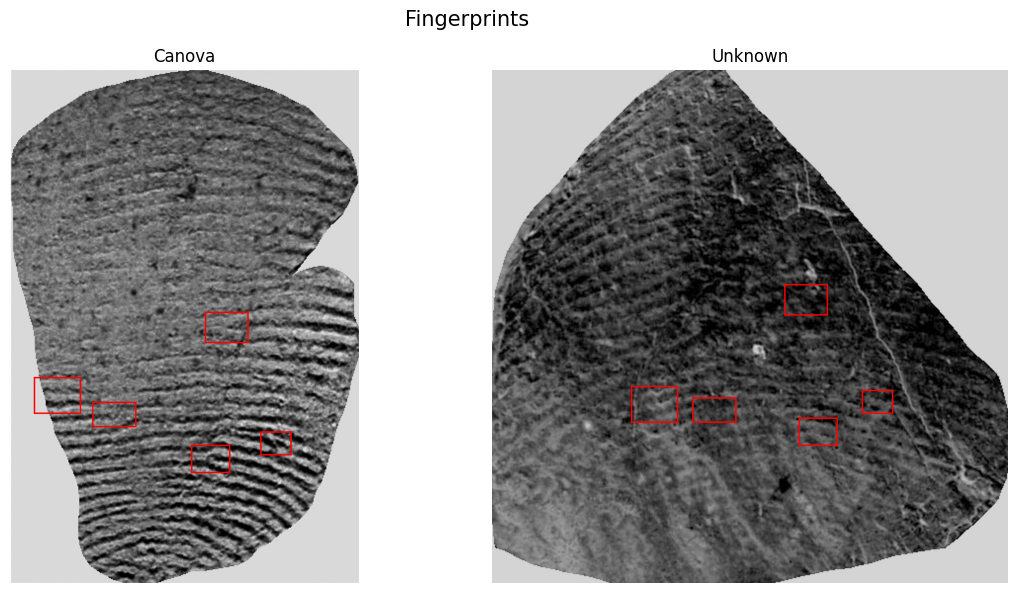

In [3]:
# plot 
fig, axs = plt.subplots(1, 2, figsize = (12, 6))
fig.suptitle('Fingerprints', fontsize = 15)

for ax, im, tit in zip(axs.flat, images, ['Canova', 'Unknown']):
    ax.imshow(im, cmap='Greys')
    ax.set_title(tit)
    ax.axis('off')

fig.tight_layout()
plt.savefig(fig_path + 'fingerprints.jpg')

In [4]:
# convert to greyscale
images = [im.convert('L') for im in images]

## Aree di interesse

In [5]:
# define boxes

vertices1 = [
    # y1 (topleft), y2, x1 (bottomright), x2 
    [491, 552, 395, 481], # box 1, in alto poi antiorario
    [623, 695, 50, 142],
    [673, 721, 168, 255],
    [760, 815, 368, 445],
    [733, 779, 508, 569]
]

vertices2 = [ 
    [435, 496, 592, 678], 
    [640, 713, 282, 376], 
    [664, 713, 406, 493], 
    [705, 760, 621, 698],
    [648, 695, 749, 810]
]

ncrops = len(vertices1)
crops = [
    [np.array(images[0])[v[0]:v[1], v[2]:v[3]] for v in vertices1],
    [np.array(images[1])[v[0]:v[1], v[2]:v[3]] for v in vertices2]
]

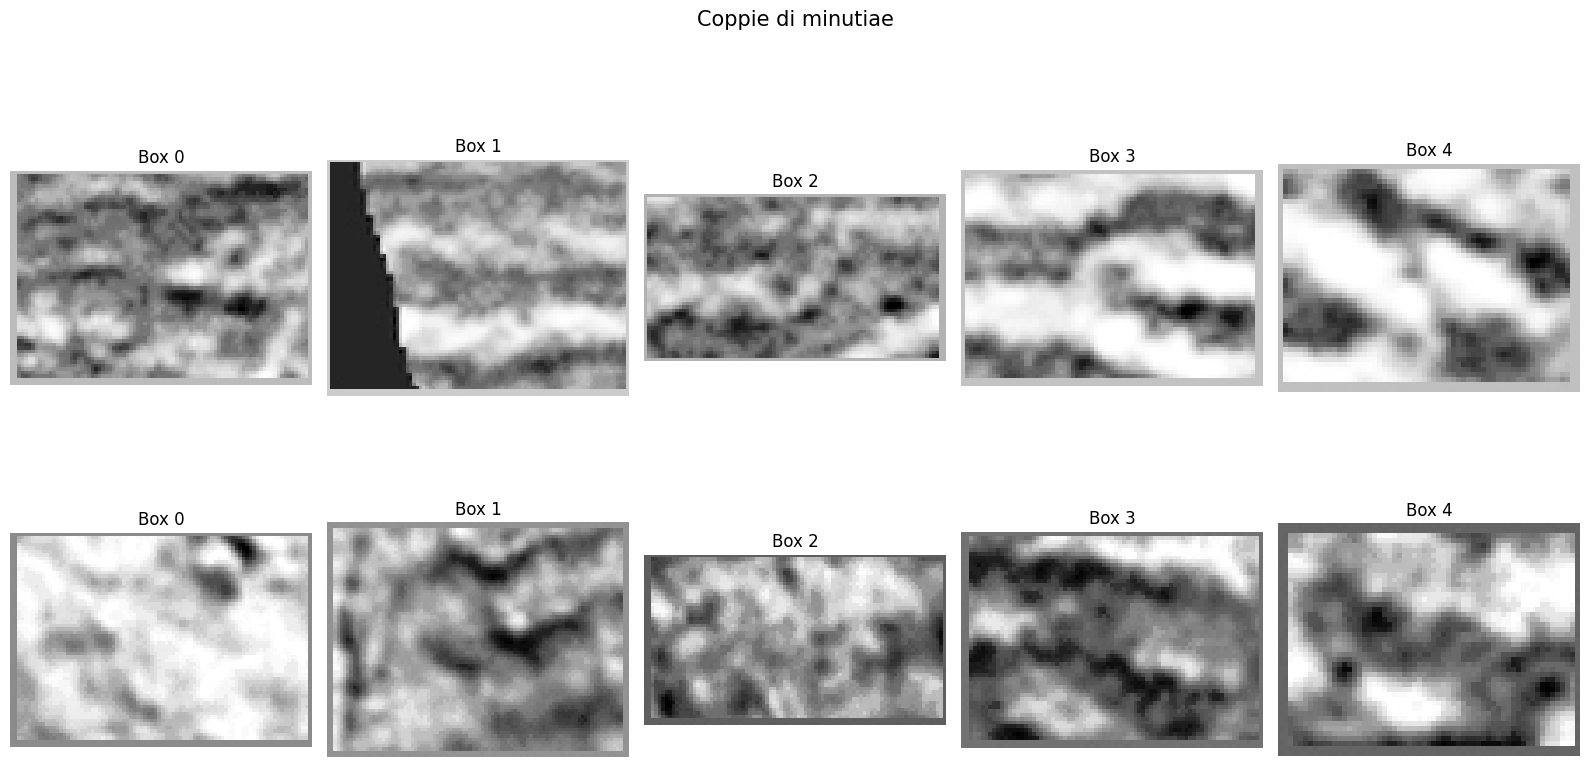

In [6]:
# plot boxes

fig, axs = plt.subplots(2, 5, figsize = (16, 9))
fig.suptitle('Coppie di minutiae', fontsize = 15)

for i in range(len(crops)):
    for j in range(ncrops):
        im = crops[i][j]
        axs[i][j].imshow(im, cmap='Greys')
        axs[i][j].axis('off')
        axs[i][j].set_title(f'Box {j}')

fig.tight_layout()
plt.savefig(fig_path + 'paired_boxes.jpg')

## Test a due campioni 

In [7]:
# helper functions

def print_results(res_dict):
    '''Print formatted result dictionary'''

    print('test\t\tstat\t\tp-value')
    print('-'*40)
    for k, v in res_dict.items():
        print(f'{k:10}\t{v[0]:.6f}\t{v[1]:.6f}') 

def two_samples_tests(x1, x2):
    '''Perform different parametric and non-parametric tests for equal location on two independent samples'''

    res = {}
    res['t-test'] = sp.stats.ttest_ind(x1, x2, equal_var=True, alternative='two-sided') # t-test with pooled variance for two independent samples
    res['welch t-test'] = sp.stats.ttest_ind(x1, x2, equal_var=False, alternative='two-sided') # t-test without assumption of equal variance
    res['yuen t-test'] = sp.stats.ttest_ind(x1, x2, equal_var=False, trim=0.1, alternative='two-sided') # t-test with trimming of each tail
    res['kruskal'] = sp.stats.kruskal(x1, x2) # non parametric test for equal median on indepdent samples
    # res['mann-whitney'] = sp.stats.mannwhitneyu(x1, x2) # non parametric test for equal distribution of two independent samples
    # res['wilcoxon'] = sp.stats.wilcoxon(x1, x2, alternative='two-sided') # non parametric test for diffrences simmetric about 0 in two paired samples

    return res

In [8]:
print('Test a due campioni per ogni box')

# get reshaped and normalized arrays
samples_mc = [crop.reshape(-1)/255 for crop in crops[0]]
samples_sg = [crop.reshape(-1)/255 for crop in crops[1]]

# test loop
results = []
for i in range(ncrops):

    # take the two samples
    x1 = samples_mc[i]
    x2 = samples_sg[i]

    # perform tests
    res = two_samples_tests(x1, x2)
    results.append(res)

    # print results
    print(f'\nBox {i+1}')
    print_results(res) 

Test a due campioni per ogni box

Box 1
test		stat		p-value
----------------------------------------
t-test    	113.919297	0.000000
welch t-test	113.919297	0.000000
yuen t-test	105.691111	0.000000
kruskal   	6044.026174	0.000000
mann-whitney	25817392.500000	0.000000

Box 2
test		stat		p-value
----------------------------------------
t-test    	66.611415	0.000000
welch t-test	65.805699	0.000000
yuen t-test	58.326827	0.000000
kruskal   	3220.319904	0.000000
mann-whitney	35548660.500000	0.000000

Box 3
test		stat		p-value
----------------------------------------
t-test    	74.984865	0.000000
welch t-test	74.643082	0.000000
yuen t-test	70.170746	0.000000
kruskal   	3494.709994	0.000000
mann-whitney	15514156.000000	0.000000

Box 4
test		stat		p-value
----------------------------------------
t-test    	10.149396	0.000000
welch t-test	10.149396	0.000000
yuen t-test	5.442453	0.000000
kruskal   	30.506046	0.000000
mann-whitney	9588927.000000	0.000000

Box 5
test		stat		p-value
-----------------

In [9]:
print('Mettendo insieme tutti i box\n')

# put every box together
mc1 = np.concatenate(samples_mc)
sg1 = np.concatenate(samples_sg)

# perform tests
res = two_samples_tests(mc1, sg1)

# print results
print_results(res)

Mettendo insieme tutti i box

test		stat		p-value
----------------------------------------
t-test    	106.200617	0.000000
welch t-test	105.765099	0.000000
yuen t-test	100.119523	0.000000
kruskal   	9180.528487	0.000000
mann-whitney	409867125.500000	0.000000
